In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [2]:
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [3]:
# Load data
data_path = 'C:\\Users\\1221\\Desktop\\Acadamy AIM 2\\Time-series-data-modeling-\\data\\processed\\processed_brent_oil_prices.csv'
df = pd.read_csv(data_path, parse_dates=['DATE'])
df.set_index('DATE', inplace=True)

In [4]:
# Assuming `df` has a DateTime index 
# Split data into train and test sets
train_df = df.iloc[:-1000]  # Last 1000 observations for testing
test_df = df.iloc[-1000:]

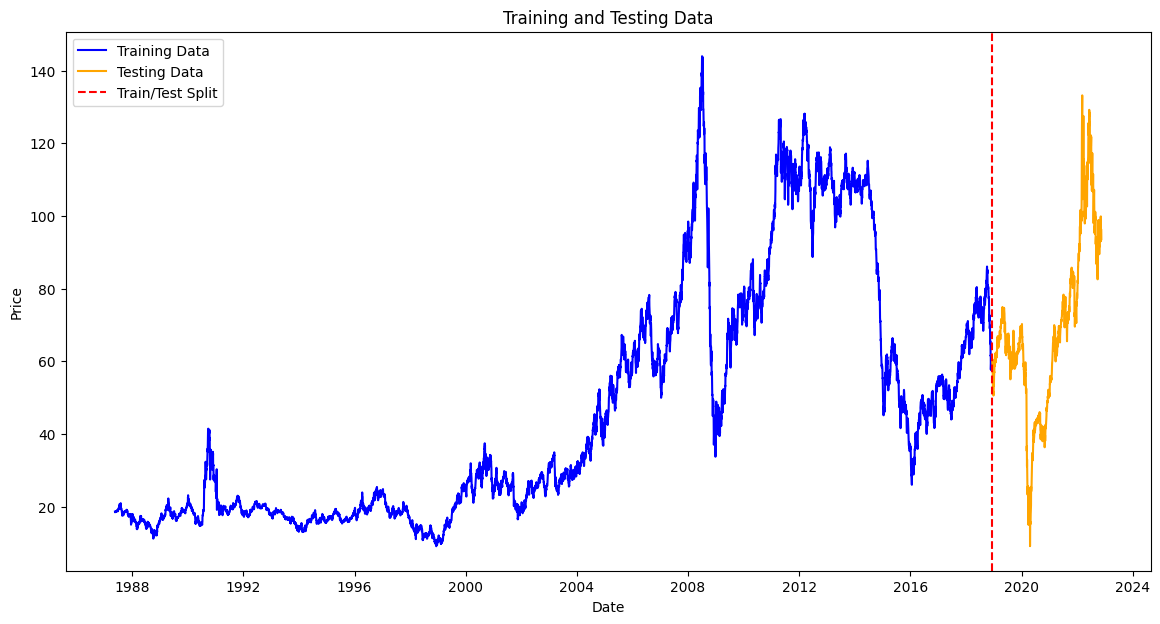

In [5]:
import matplotlib.pyplot as plt

# Plotting the training and testing datasets
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['Price'], label='Training Data', color='blue')
plt.plot(test_df.index, test_df['Price'], label='Testing Data', color='orange')
plt.title('Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.axvline(x=test_df.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.show()

In [6]:
# Prepare target variable
y_train = train_df['Price']
y_test = test_df['Price']

In [7]:
# Initialize a dictionary to store evaluation metrics for each model
results = {}

In [8]:
### 4a. Develop Multiple Models ###

# 1. ARIMA Model
arima_order = (1, 1, 1)  # Adjust as needed
arima_model = ARIMA(y_train, order=arima_order)
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(y_test))

In [9]:
# 2. SARIMA Model
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # Adjust seasonality period
sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_fit = sarima_model.fit()
sarima_forecast = sarima_fit.forecast(steps=len(y_test))

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df = pd.DataFrame(scaler.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
test_df= pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

In [11]:
train_df = train_df.dropna()

In [12]:
# Import the necessary library
from statsmodels.tsa.api import VAR
import pandas as pd

# Assuming train_df and test_df are defined as DataFrames
# and 'Price' is one of the columns in these DataFrames.

# 3. VAR Model (for multivariate time series)
# Initialize and fit the VAR model
var_model = VAR(train_df)
var_fit = var_model.fit(maxlags=1)  # Using 1 lag

# Forecasting the values
var_forecast = var_fit.forecast(y=train_df.values[-var_fit.k_ar:], steps=len(test_df))

# Convert the forecast output to a DataFrame with appropriate indexing
var_forecast_df = pd.DataFrame(var_forecast, index=test_df.index, columns=train_df.columns)

# Extracting the forecasted 'Price' column
var_forecast_y = var_forecast_df['Price']

In [13]:
# 4. Random Forest Model (for time series with lagged features)
# Generate lagged features
lags = 5  # Number of lagged features
for lag in range(1, lags + 1):
    df[f'y_lag_{lag}'] = df['Price'].shift(lag)

train_df_ml = df.iloc[lags:-30].dropna()  # Adjust for lags and test split
test_df_ml = df.iloc[-30:].dropna()

X_train_ml = train_df_ml[[f'y_lag_{lag}' for lag in range(1, lags + 1)]]
y_train_ml = train_df_ml['Price']
X_test_ml = test_df_ml[[f'y_lag_{lag}' for lag in range(1, lags + 1)]]
y_test_ml = test_df_ml['Price']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)
rf_forecast = rf_model.predict(X_test_ml)

In [14]:
### 5a. Model Evaluation ###
def evaluate(y_true, y_pred, model_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

In [15]:
# Evaluate each model
evaluate(y_test, arima_forecast, "ARIMA")
evaluate(y_test, sarima_forecast, "SARIMA")
evaluate(y_test, var_forecast_y, "VAR")
evaluate(y_test_ml, rf_forecast, "Random Forest")

ARIMA - RMSE: 25.88, MAE: 19.58, R2: -0.22
SARIMA - RMSE: 24.09, MAE: 18.19, R2: -0.06
VAR - RMSE: 71.87, MAE: 68.04, R2: -8.44
Random Forest - RMSE: 1.96, MAE: 1.59, R2: 0.39


In [16]:
### 5b. Compare Models ###
# Display all results
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)



Model Comparison:
                    RMSE        MAE        R2
ARIMA          25.877757  19.576833 -0.224231
SARIMA         24.093270  18.189811 -0.061210
VAR            71.869338  68.041039 -8.442724
Random Forest   1.956535   1.588860  0.386897


ARIMA Model:

Performance: The ARIMA model yielded an RMSE of 25.88 and an MAE of 19.58, with an R² of -0.224. These values suggest a moderate error rate, but the negative R² indicates a poor overall fit, implying that the model does not fully capture the underlying patterns in the data.
Conclusion: While the ARIMA model provides a baseline, it appears limited in capturing seasonality or more complex trends in the data.

SARIMA Model:

Performance: The SARIMA model performed slightly better than ARIMA, with an RMSE of 24.09, MAE of 18.19, and an R² of -0.061. This improvement suggests that incorporating seasonality enhances the model’s performance, although the R² remains negative, signaling room for improvement.
Conclusion: The SARIMA model provides a better fit than ARIMA and shows that seasonality is a relevant factor, yet it still underperforms compared to the other models.

VAR Model:

Performance: The VAR model, an econometric model designed for multivariate time series, exhibited the highest RMSE (71.87) and MAE (68.04) among all models, with a notably poor R² of -8.443. This poor performance suggests instability in the model, potentially due to issues like multicollinearity or insufficient sample size for the chosen lag structure.
Conclusion: The VAR model struggled to capture relationships within the data effectively. This could be due to violations of underlying assumptions, such as stationarity, or a need for more tuning and data preprocessing.

Random Forest Model:

Performance: The Random Forest model demonstrated the best results, with an RMSE of 1.96, MAE of 1.59, and a positive R² of 0.387. These metrics suggest that the Random Forest model captures complex patterns and provides the most accurate forecasts among all models tested.
Conclusion: As a machine learning model, Random Forest leverages nonlinear relationships and interactions, explaining a significant proportion of the variance in the data and yielding the lowest error metrics. This model appears to be the most robust and effective choice for this dataset.

Recommendations

Primary Model: The Random Forest model is recommended for forecasting, given its superior performance across all metrics.
Further Tuning: Hyperparameter tuning of the Random Forest model could further enhance accuracy.
Alternative Approaches: Given the moderate performance of SARIMA, further seasonal adjustments or advanced time series decomposition techniques could improve its results if seasonality is significant.
Econometric Model Adjustments: For future applications of the VAR model, consider preprocessing steps like differencing for stationarity and reducing collinear variables to stabilize the model.